In [1]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

### 데이터 불러오기

In [2]:
dataset=read_csv('set2.csv',index_col=0)
dataset1=dataset[['apt','fed','inc','savings','kospi','hccsi']]
dataset2=dataset[['apt','fed','kospi','hccsi']]
dataset3=dataset[['apt','inc','savings','hccsi']]
dataset4=dataset[['apt','hloan','ir','cpi','fed','inc','exp','savings','kospi','hccsi','bond','m2']]

### LSTM 준비

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i >= 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# #1-1
n_months=3  
n_features=6  
apt, fed, inc, savings, kospi, hccsi

In [4]:
# load dataset
dataset1
values = dataset1.values

In [5]:
# ensure all data is float
values = values.astype('float32')

### 데이터 정규화

In [6]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

In [7]:
# scaler = StandardScaler()
scaled = scaler.fit_transform(values)

### lag, feature 수 설정

In [8]:
# specify the number of lag months
n_months=3
n_features=6

In [9]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
reframed2 = series_to_supervised(scaled, n_months, 1)

### 독립 변수 열 삭제

In [10]:
drop_col = list(range(0,n_features*n_months,n_features))+list(range(n_features*n_months+1,n_features*(n_months+1)))

In [11]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)
print(reframed.head())

   var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  var2(t-2)  \
3        0.0   0.012027   0.200222   0.338362   0.848485        0.0   
4        0.0   0.012027   0.200222   0.112144   0.947475        0.0   
5        0.0   0.012027   0.200222   0.013416   0.856566        0.0   
6        0.0   0.000000   0.300560   0.137992   0.650505        0.0   
7        0.0   0.000000   0.300560   0.083006   0.472727        0.0   

   var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  var2(t-1)  var3(t-1)  \
3   0.012027   0.200222   0.112144   0.947475        0.0   0.012027   
4   0.012027   0.200222   0.013416   0.856566        0.0   0.000000   
5   0.000000   0.300560   0.137992   0.650505        0.0   0.000000   
6   0.000000   0.300560   0.083006   0.472727        0.0   0.000000   
7   0.000000   0.300560   0.063549   0.400000        0.0   0.202585   

   var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  
3   0.200222   0.013416   0.856566  0.058888  
4   0.300560   0.137992   0.650505  0.048160  
5   0

### train, test set 나누기

In [12]:
# split into train and test sets
values = reframed.values
n_train_months = 40
train = values[:n_train_months, :]
test = values[n_train_months:, :]

In [13]:
# split into input and outputs
train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 

In [14]:
print(train_X.shape,train_y.shape)

(40, 15) (40,)


In [15]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features-1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(40, 3, 5) (40,) (71, 3, 5) (71,)


### 모델 디자인

In [16]:
# design network
learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

### LSTM

In [17]:
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/200
3/3 - 6s - loss: 0.0558 - val_loss: 0.3181
Epoch 2/200
3/3 - 0s - loss: 0.0695 - val_loss: 0.3479
Epoch 3/200
3/3 - 0s - loss: 0.0495 - val_loss: 0.2616
Epoch 4/200
3/3 - 0s - loss: 0.0576 - val_loss: 0.2399
Epoch 5/200
3/3 - 0s - loss: 0.0514 - val_loss: 0.2442
Epoch 6/200
3/3 - 0s - loss: 0.0345 - val_loss: 0.1855
Epoch 7/200
3/3 - 0s - loss: 0.0328 - val_loss: 0.1498
Epoch 8/200
3/3 - 0s - loss: 0.0297 - val_loss: 0.1342
Epoch 9/200
3/3 - 0s - loss: 0.0296 - val_loss: 0.1264
Epoch 10/200
3/3 - 0s - loss: 0.0301 - val_loss: 0.1359
Epoch 11/200
3/3 - 0s - loss: 0.0333 - val_loss: 0.1412
Epoch 12/200
3/3 - 0s - loss: 0.0268 - val_loss: 0.1395
Epoch 13/200
3/3 - 0s - loss: 0.0289 - val_loss: 0.1642
Epoch 14/200
3/3 - 0s - loss: 0.0249 - val_loss: 0.1494
Epoch 15/200
3/3 - 0s - loss: 0.0285 - val_loss: 0.1637
Epoch 16/200
3/3 - 0s - loss: 0.0271 - val_loss: 0.1499
Epoch 17/200
3/3 - 0s - loss: 0.0249 - val_loss: 0.1406
Epoch 18/200
3/3 - 0s - loss: 0.0262 - val_loss: 0.1432
E

Epoch 147/200
3/3 - 0s - loss: 0.0269 - val_loss: 0.2141
Epoch 148/200
3/3 - 0s - loss: 0.0191 - val_loss: 0.2354
Epoch 149/200
3/3 - 0s - loss: 0.0152 - val_loss: 0.2081
Epoch 150/200
3/3 - 0s - loss: 0.0327 - val_loss: 0.2024
Epoch 151/200
3/3 - 0s - loss: 0.0200 - val_loss: 0.2213
Epoch 152/200
3/3 - 0s - loss: 0.0277 - val_loss: 0.1907
Epoch 153/200
3/3 - 0s - loss: 0.0360 - val_loss: 0.1894
Epoch 154/200
3/3 - 0s - loss: 0.0247 - val_loss: 0.2344
Epoch 155/200
3/3 - 0s - loss: 0.0240 - val_loss: 0.2126
Epoch 156/200
3/3 - 0s - loss: 0.0207 - val_loss: 0.2075
Epoch 157/200
3/3 - 0s - loss: 0.0176 - val_loss: 0.2201
Epoch 158/200
3/3 - 0s - loss: 0.0165 - val_loss: 0.2124
Epoch 159/200
3/3 - 0s - loss: 0.0163 - val_loss: 0.2158
Epoch 160/200
3/3 - 0s - loss: 0.0138 - val_loss: 0.1965
Epoch 161/200
3/3 - 0s - loss: 0.0164 - val_loss: 0.1902
Epoch 162/200
3/3 - 0s - loss: 0.0164 - val_loss: 0.1909
Epoch 163/200
3/3 - 0s - loss: 0.0179 - val_loss: 0.1920
Epoch 164/200
3/3 - 0s - loss: 

### loss plot

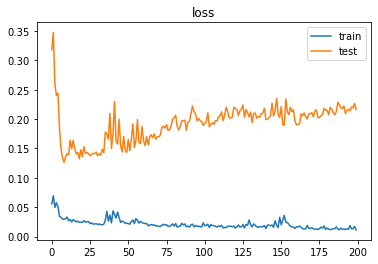

In [18]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('loss')
plt.show()

### 예측 모델

In [19]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*(n_features-1)))

In [20]:
yhat=yhat[:,0]
yhat=yhat.reshape(test_X.shape[0],1)

### 정규화 전 기존 값으로 invert

In [21]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [22]:
# invert scaling for actual
test_y=test_y.reshape(test_X.shape[0],1)
inv_y = np.concatenate((test_y, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [23]:
yhat=inv_yhat
test_y=inv_y

### RMSE

In [24]:
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 79.786


### 예측 결과 plot

In [25]:
features=[yhat,test_y]

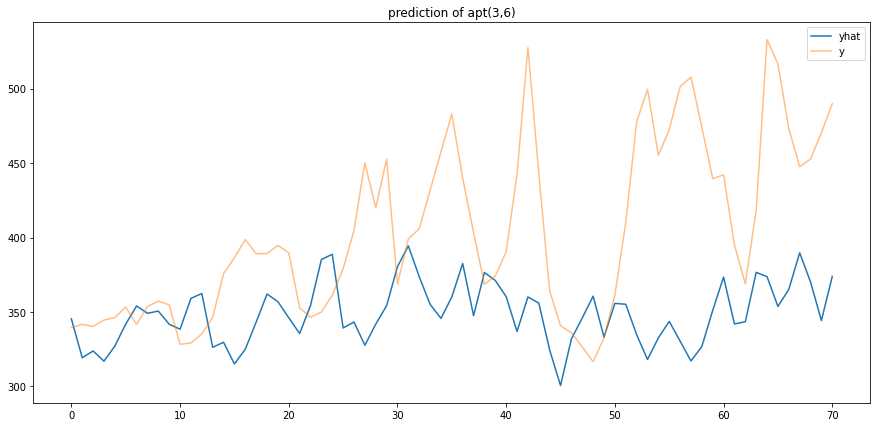

In [26]:
plt.figure(figsize=(15,7))
plt.title('prediction of apt({},{})'.format(n_months,n_features))
plt.plot(yhat,label='yhat')
plt.plot(test_y,alpha=0.5,label='y')
plt.legend()
plt.show()

# #1-2
n_months=12  
n_features=6  
apt, fed, inc, savings, kospi, hccsi

In [27]:
values = dataset1.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_months=12
n_features=6

reframed = series_to_supervised(scaled, n_months, 1)
reframed2 = series_to_supervised(scaled, n_months, 1)

drop_col = list(range(0,n_features*n_months,n_features))+list(range(n_features*n_months+1,n_features*(n_months+1)))
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

values = reframed.values
n_train_months = 40
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 

train_X = train_X.reshape((train_X.shape[0], n_months, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features-1))

learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

history = model.fit(train_X, train_y, epochs=200, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/200
3/3 - 4s - loss: 0.2083 - val_loss: 0.4852
Epoch 2/200
3/3 - 0s - loss: 0.1952 - val_loss: 0.6434
Epoch 3/200
3/3 - 0s - loss: 0.1537 - val_loss: 0.4066
Epoch 4/200
3/3 - 0s - loss: 0.0592 - val_loss: 0.2746
Epoch 5/200
3/3 - 0s - loss: 0.1205 - val_loss: 0.3022
Epoch 6/200
3/3 - 0s - loss: 0.0906 - val_loss: 0.3985
Epoch 7/200
3/3 - 0s - loss: 0.0740 - val_loss: 0.4010
Epoch 8/200
3/3 - 0s - loss: 0.0589 - val_loss: 0.3414
Epoch 9/200
3/3 - 0s - loss: 0.0481 - val_loss: 0.2718
Epoch 10/200
3/3 - 0s - loss: 0.0641 - val_loss: 0.2483
Epoch 11/200
3/3 - 0s - loss: 0.0655 - val_loss: 0.2740
Epoch 12/200
3/3 - 0s - loss: 0.0502 - val_loss: 0.2794
Epoch 13/200
3/3 - 0s - loss: 0.0382 - val_loss: 0.2356
Epoch 14/200
3/3 - 0s - loss: 0.0297 - val_loss: 0.1915
Epoch 15/200
3/3 - 0s - loss: 0.0281 - val_loss: 0.1873
Epoch 16/200
3/3 - 0s - loss: 0.0348 - val_loss: 0.1860
Epoch 17/200
3/3 - 0s - loss: 0.0311 - val_loss: 0.1986
Epoch 18/200
3/3 - 0s - loss: 0.0272 - val_loss: 0.2077
E

Epoch 147/200
3/3 - 0s - loss: 0.0221 - val_loss: 0.1766
Epoch 148/200
3/3 - 0s - loss: 0.0227 - val_loss: 0.1894
Epoch 149/200
3/3 - 0s - loss: 0.0165 - val_loss: 0.1663
Epoch 150/200
3/3 - 0s - loss: 0.0414 - val_loss: 0.1672
Epoch 151/200
3/3 - 0s - loss: 0.0258 - val_loss: 0.2080
Epoch 152/200
3/3 - 0s - loss: 0.0263 - val_loss: 0.1949
Epoch 153/200
3/3 - 0s - loss: 0.0177 - val_loss: 0.1774
Epoch 154/200
3/3 - 0s - loss: 0.0178 - val_loss: 0.1888
Epoch 155/200
3/3 - 0s - loss: 0.0164 - val_loss: 0.1780
Epoch 156/200
3/3 - 0s - loss: 0.0167 - val_loss: 0.1745
Epoch 157/200
3/3 - 0s - loss: 0.0170 - val_loss: 0.1712
Epoch 158/200
3/3 - 0s - loss: 0.0152 - val_loss: 0.1712
Epoch 159/200
3/3 - 0s - loss: 0.0174 - val_loss: 0.1749
Epoch 160/200
3/3 - 0s - loss: 0.0142 - val_loss: 0.1648
Epoch 161/200
3/3 - 0s - loss: 0.0139 - val_loss: 0.1662
Epoch 162/200
3/3 - 0s - loss: 0.0160 - val_loss: 0.1650
Epoch 163/200
3/3 - 0s - loss: 0.0178 - val_loss: 0.1728
Epoch 164/200
3/3 - 0s - loss: 

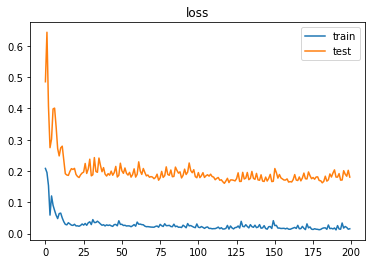

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('loss')
plt.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*(n_features-1)))
yhat=yhat[:,0]
yhat=yhat.reshape(test_X.shape[0],1)

inv_yhat = np.concatenate((yhat, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y=test_y.reshape(test_X.shape[0],1)
inv_y = np.concatenate((test_y, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

yhat=inv_yhat
test_y=inv_y

In [29]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 66.352


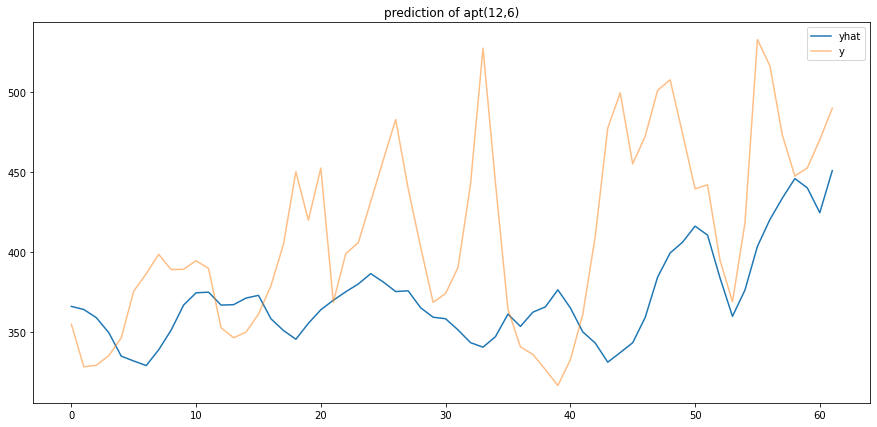

In [30]:
features=[yhat,test_y]

plt.figure(figsize=(15,7))
plt.title('prediction of apt({},{})'.format(n_months,n_features))
plt.plot(yhat,label='yhat')
plt.plot(test_y,alpha=0.5,label='y')
plt.legend()
plt.show()

# #2-1
n_months=3  
n_features=4  
apt, fed, kospi, hccsi

In [31]:
values = dataset2.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_months=3
n_features=4

reframed = series_to_supervised(scaled, n_months, 1)
reframed2 = series_to_supervised(scaled, n_months, 1)

drop_col = list(range(0,n_features*n_months,n_features))+list(range(n_features*n_months+1,n_features*(n_months+1)))
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

values = reframed.values
n_train_months = 40
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 

train_X = train_X.reshape((train_X.shape[0], n_months, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features-1))

learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

history = model.fit(train_X, train_y, epochs=200, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/200
3/3 - 4s - loss: 0.0511 - val_loss: 0.2826
Epoch 2/200
3/3 - 0s - loss: 0.1209 - val_loss: 0.3944
Epoch 3/200
3/3 - 0s - loss: 0.0718 - val_loss: 0.4308
Epoch 4/200
3/3 - 0s - loss: 0.0620 - val_loss: 0.4177
Epoch 5/200
3/3 - 0s - loss: 0.0530 - val_loss: 0.3876
Epoch 6/200
3/3 - 0s - loss: 0.0588 - val_loss: 0.3692
Epoch 7/200
3/3 - 0s - loss: 0.0657 - val_loss: 0.3698
Epoch 8/200
3/3 - 0s - loss: 0.0661 - val_loss: 0.3830
Epoch 9/200
3/3 - 0s - loss: 0.0617 - val_loss: 0.3987
Epoch 10/200
3/3 - 0s - loss: 0.0569 - val_loss: 0.4114
Epoch 11/200
3/3 - 0s - loss: 0.0533 - val_loss: 0.4109
Epoch 12/200
3/3 - 0s - loss: 0.0504 - val_loss: 0.3972
Epoch 13/200
3/3 - 0s - loss: 0.0519 - val_loss: 0.3855
Epoch 14/200
3/3 - 0s - loss: 0.0548 - val_loss: 0.3819
Epoch 15/200
3/3 - 0s - loss: 0.0553 - val_loss: 0.3858
Epoch 16/200
3/3 - 0s - loss: 0.0530 - val_loss: 0.3929
Epoch 17/200
3/3 - 0s - loss: 0.0503 - val_loss: 0.3917
Epoch 18/200
3/3 - 0s - loss: 0.0487 - val_loss: 0.3820
E

Epoch 147/200
3/3 - 0s - loss: 0.0425 - val_loss: 0.3822
Epoch 148/200
3/3 - 0s - loss: 0.0361 - val_loss: 0.3795
Epoch 149/200
3/3 - 0s - loss: 0.0354 - val_loss: 0.3654
Epoch 150/200
3/3 - 0s - loss: 0.0353 - val_loss: 0.3615
Epoch 151/200
3/3 - 0s - loss: 0.0352 - val_loss: 0.3711
Epoch 152/200
3/3 - 0s - loss: 0.0354 - val_loss: 0.3747
Epoch 153/200
3/3 - 0s - loss: 0.0341 - val_loss: 0.3732
Epoch 154/200
3/3 - 0s - loss: 0.0337 - val_loss: 0.3620
Epoch 155/200
3/3 - 0s - loss: 0.0360 - val_loss: 0.3712
Epoch 156/200
3/3 - 0s - loss: 0.0358 - val_loss: 0.3727
Epoch 157/200
3/3 - 0s - loss: 0.0337 - val_loss: 0.3751
Epoch 158/200
3/3 - 0s - loss: 0.0359 - val_loss: 0.3748
Epoch 159/200
3/3 - 0s - loss: 0.0333 - val_loss: 0.3533
Epoch 160/200
3/3 - 0s - loss: 0.0366 - val_loss: 0.3680
Epoch 161/200
3/3 - 0s - loss: 0.0354 - val_loss: 0.3822
Epoch 162/200
3/3 - 0s - loss: 0.0325 - val_loss: 0.3718
Epoch 163/200
3/3 - 0s - loss: 0.0384 - val_loss: 0.3739
Epoch 164/200
3/3 - 0s - loss: 

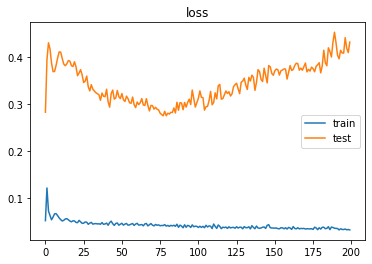

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('loss')
plt.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*(n_features-1)))
yhat=yhat[:,0]
yhat=yhat.reshape(test_X.shape[0],1)

inv_yhat = np.concatenate((yhat, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y=test_y.reshape(test_X.shape[0],1)
inv_y = np.concatenate((test_y, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

yhat=inv_yhat
test_y=inv_y

In [33]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 144.222


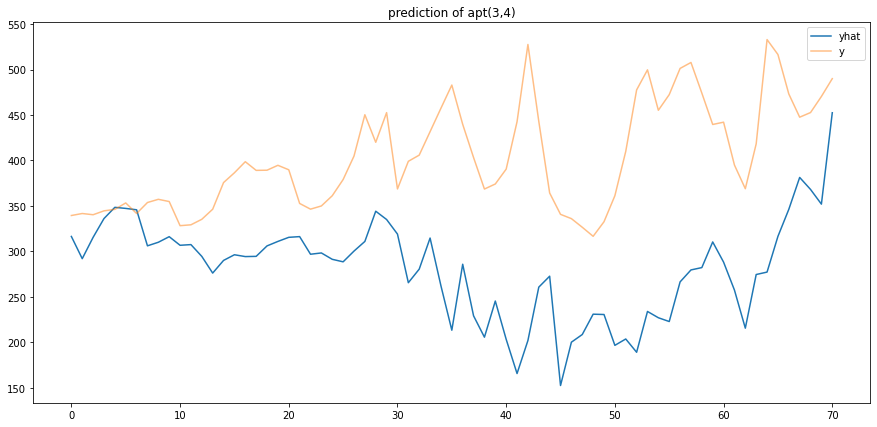

In [34]:
features=[yhat,test_y]

plt.figure(figsize=(15,7))
plt.title('prediction of apt({},{})'.format(n_months,n_features))
plt.plot(yhat,label='yhat')
plt.plot(test_y,alpha=0.5,label='y')
plt.legend()
plt.show()

# #2-2
n_months=12  
n_features=4  
apt, fed, kospi, hccsi

In [35]:
values = dataset2.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_months=12
n_features=4

reframed = series_to_supervised(scaled, n_months, 1)
reframed2 = series_to_supervised(scaled, n_months, 1)

drop_col = list(range(0,n_features*n_months,n_features))+list(range(n_features*n_months+1,n_features*(n_months+1)))
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

values = reframed.values
n_train_months = 40
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 

train_X = train_X.reshape((train_X.shape[0], n_months, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features-1))

learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

history = model.fit(train_X, train_y, epochs=200, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/200
3/3 - 4s - loss: 0.1464 - val_loss: 0.4264
Epoch 2/200
3/3 - 0s - loss: 0.1705 - val_loss: 0.5125
Epoch 3/200
3/3 - 0s - loss: 0.1052 - val_loss: 0.3834
Epoch 4/200
3/3 - 0s - loss: 0.0683 - val_loss: 0.3408
Epoch 5/200
3/3 - 0s - loss: 0.1047 - val_loss: 0.3738
Epoch 6/200
3/3 - 0s - loss: 0.0872 - val_loss: 0.4294
Epoch 7/200
3/3 - 0s - loss: 0.0699 - val_loss: 0.4518
Epoch 8/200
3/3 - 0s - loss: 0.0603 - val_loss: 0.4404
Epoch 9/200
3/3 - 0s - loss: 0.0548 - val_loss: 0.4204
Epoch 10/200
3/3 - 0s - loss: 0.0643 - val_loss: 0.4203
Epoch 11/200
3/3 - 0s - loss: 0.0692 - val_loss: 0.4447
Epoch 12/200
3/3 - 0s - loss: 0.0622 - val_loss: 0.4845
Epoch 13/200
3/3 - 0s - loss: 0.0489 - val_loss: 0.5170
Epoch 14/200
3/3 - 0s - loss: 0.0387 - val_loss: 0.5466
Epoch 15/200
3/3 - 0s - loss: 0.0437 - val_loss: 0.6088
Epoch 16/200
3/3 - 0s - loss: 0.0578 - val_loss: 0.5799
Epoch 17/200
3/3 - 0s - loss: 0.0488 - val_loss: 0.5064
Epoch 18/200
3/3 - 0s - loss: 0.0479 - val_loss: 0.5327
E

Epoch 147/200
3/3 - 0s - loss: 0.0310 - val_loss: 0.3926
Epoch 148/200
3/3 - 0s - loss: 0.0355 - val_loss: 0.4021
Epoch 149/200
3/3 - 0s - loss: 0.0353 - val_loss: 0.4240
Epoch 150/200
3/3 - 0s - loss: 0.0318 - val_loss: 0.3867
Epoch 151/200
3/3 - 0s - loss: 0.0413 - val_loss: 0.3884
Epoch 152/200
3/3 - 0s - loss: 0.0353 - val_loss: 0.4217
Epoch 153/200
3/3 - 0s - loss: 0.0344 - val_loss: 0.4003
Epoch 154/200
3/3 - 0s - loss: 0.0307 - val_loss: 0.3833
Epoch 155/200
3/3 - 0s - loss: 0.0344 - val_loss: 0.4070
Epoch 156/200
3/3 - 0s - loss: 0.0287 - val_loss: 0.4223
Epoch 157/200
3/3 - 0s - loss: 0.0298 - val_loss: 0.4156
Epoch 158/200
3/3 - 0s - loss: 0.0288 - val_loss: 0.4165
Epoch 159/200
3/3 - 0s - loss: 0.0297 - val_loss: 0.4115
Epoch 160/200
3/3 - 0s - loss: 0.0291 - val_loss: 0.4025
Epoch 161/200
3/3 - 0s - loss: 0.0315 - val_loss: 0.4059
Epoch 162/200
3/3 - 0s - loss: 0.0278 - val_loss: 0.3878
Epoch 163/200
3/3 - 0s - loss: 0.0327 - val_loss: 0.3934
Epoch 164/200
3/3 - 0s - loss: 

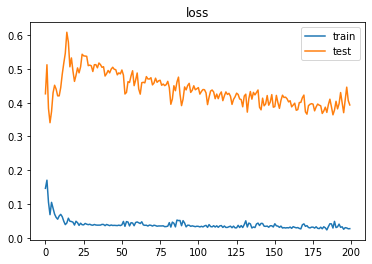

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('loss')
plt.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*(n_features-1)))
yhat=yhat[:,0]
yhat=yhat.reshape(test_X.shape[0],1)

inv_yhat = np.concatenate((yhat, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y=test_y.reshape(test_X.shape[0],1)
inv_y = np.concatenate((test_y, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

yhat=inv_yhat
test_y=inv_y

In [37]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 127.115


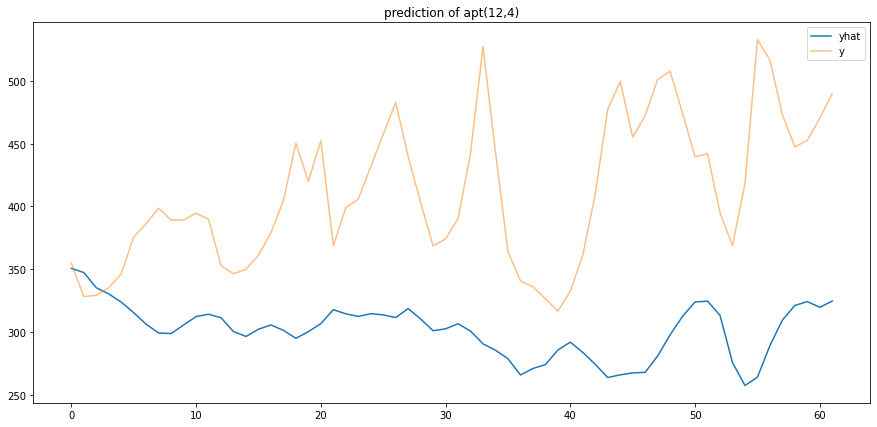

In [38]:
features=[yhat,test_y]

plt.figure(figsize=(15,7))
plt.title('prediction of apt({},{})'.format(n_months,n_features))
plt.plot(yhat,label='yhat')
plt.plot(test_y,alpha=0.5,label='y')
plt.legend()
plt.show()

# #3-1
n_months=3  
n_features=4  
apt, inc, savings, hccsi

In [39]:
values = dataset3.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_months=3
n_features=4

reframed = series_to_supervised(scaled, n_months, 1)
reframed2 = series_to_supervised(scaled, n_months, 1)

drop_col = list(range(0,n_features*n_months,n_features))+list(range(n_features*n_months+1,n_features*(n_months+1)))
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

values = reframed.values
n_train_months = 40
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 

train_X = train_X.reshape((train_X.shape[0], n_months, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features-1))

learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

history = model.fit(train_X, train_y, epochs=200, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/200
3/3 - 4s - loss: 0.0641 - val_loss: 0.3511
Epoch 2/200
3/3 - 0s - loss: 0.0738 - val_loss: 0.3384
Epoch 3/200
3/3 - 0s - loss: 0.0561 - val_loss: 0.2838
Epoch 4/200
3/3 - 0s - loss: 0.0556 - val_loss: 0.2620
Epoch 5/200
3/3 - 0s - loss: 0.0465 - val_loss: 0.2402
Epoch 6/200
3/3 - 0s - loss: 0.0345 - val_loss: 0.1921
Epoch 7/200
3/3 - 0s - loss: 0.0319 - val_loss: 0.1602
Epoch 8/200
3/3 - 0s - loss: 0.0281 - val_loss: 0.1304
Epoch 9/200
3/3 - 0s - loss: 0.0302 - val_loss: 0.1299
Epoch 10/200
3/3 - 0s - loss: 0.0299 - val_loss: 0.1342
Epoch 11/200
3/3 - 0s - loss: 0.0281 - val_loss: 0.1339
Epoch 12/200
3/3 - 0s - loss: 0.0307 - val_loss: 0.1598
Epoch 13/200
3/3 - 0s - loss: 0.0310 - val_loss: 0.1413
Epoch 14/200
3/3 - 0s - loss: 0.0335 - val_loss: 0.1518
Epoch 15/200
3/3 - 0s - loss: 0.0319 - val_loss: 0.1594
Epoch 16/200
3/3 - 0s - loss: 0.0267 - val_loss: 0.1492
Epoch 17/200
3/3 - 0s - loss: 0.0276 - val_loss: 0.1531
Epoch 18/200
3/3 - 0s - loss: 0.0262 - val_loss: 0.1365
E

Epoch 147/200
3/3 - 0s - loss: 0.0163 - val_loss: 0.2374
Epoch 148/200
3/3 - 0s - loss: 0.0180 - val_loss: 0.2472
Epoch 149/200
3/3 - 0s - loss: 0.0157 - val_loss: 0.2283
Epoch 150/200
3/3 - 0s - loss: 0.0204 - val_loss: 0.2220
Epoch 151/200
3/3 - 0s - loss: 0.0173 - val_loss: 0.2323
Epoch 152/200
3/3 - 0s - loss: 0.0176 - val_loss: 0.2344
Epoch 153/200
3/3 - 0s - loss: 0.0182 - val_loss: 0.2389
Epoch 154/200
3/3 - 0s - loss: 0.0157 - val_loss: 0.2236
Epoch 155/200
3/3 - 0s - loss: 0.0174 - val_loss: 0.2145
Epoch 156/200
3/3 - 0s - loss: 0.0171 - val_loss: 0.2232
Epoch 157/200
3/3 - 0s - loss: 0.0145 - val_loss: 0.2159
Epoch 158/200
3/3 - 0s - loss: 0.0152 - val_loss: 0.2255
Epoch 159/200
3/3 - 0s - loss: 0.0145 - val_loss: 0.2301
Epoch 160/200
3/3 - 0s - loss: 0.0156 - val_loss: 0.2250
Epoch 161/200
3/3 - 0s - loss: 0.0145 - val_loss: 0.2259
Epoch 162/200
3/3 - 0s - loss: 0.0163 - val_loss: 0.2388
Epoch 163/200
3/3 - 0s - loss: 0.0209 - val_loss: 0.2500
Epoch 164/200
3/3 - 0s - loss: 

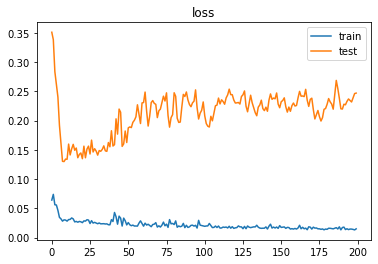

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('loss')
plt.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*(n_features-1)))
yhat=yhat[:,0]
yhat=yhat.reshape(test_X.shape[0],1)

inv_yhat = np.concatenate((yhat, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y=test_y.reshape(test_X.shape[0],1)
inv_y = np.concatenate((test_y, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

yhat=inv_yhat
test_y=inv_y

In [41]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 88.389


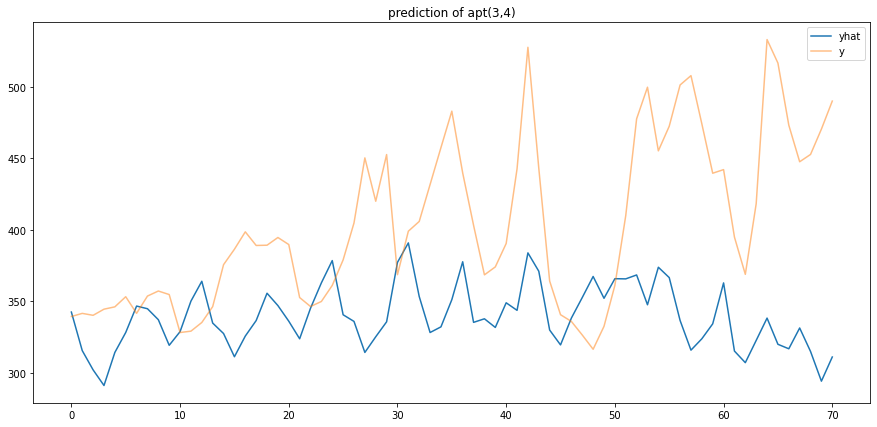

In [42]:
features=[yhat,test_y]

plt.figure(figsize=(15,7))
plt.title('prediction of apt({},{})'.format(n_months,n_features))
plt.plot(yhat,label='yhat')
plt.plot(test_y,alpha=0.5,label='y')
plt.legend()
plt.show()

# #3-2
n_months=12  
n_features=4  
apt, inc, savings, hccsi

In [43]:
values = dataset3.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_months=12
n_features=4

reframed = series_to_supervised(scaled, n_months, 1)
reframed2 = series_to_supervised(scaled, n_months, 1)

drop_col = list(range(0,n_features*n_months,n_features))+list(range(n_features*n_months+1,n_features*(n_months+1)))
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

values = reframed.values
n_train_months = 40
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 

train_X = train_X.reshape((train_X.shape[0], n_months, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features-1))

learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

history = model.fit(train_X, train_y, epochs=200, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/200
3/3 - 4s - loss: 0.1413 - val_loss: 0.2105
Epoch 2/200
3/3 - 0s - loss: 0.0918 - val_loss: 0.2653
Epoch 3/200
3/3 - 0s - loss: 0.0581 - val_loss: 0.2237
Epoch 4/200
3/3 - 0s - loss: 0.0422 - val_loss: 0.1693
Epoch 5/200
3/3 - 0s - loss: 0.0597 - val_loss: 0.1666
Epoch 6/200
3/3 - 0s - loss: 0.0379 - val_loss: 0.1483
Epoch 7/200
3/3 - 0s - loss: 0.0335 - val_loss: 0.1506
Epoch 8/200
3/3 - 0s - loss: 0.0534 - val_loss: 0.1467
Epoch 9/200
3/3 - 0s - loss: 0.0461 - val_loss: 0.1531
Epoch 10/200
3/3 - 0s - loss: 0.0399 - val_loss: 0.2104
Epoch 11/200
3/3 - 0s - loss: 0.0387 - val_loss: 0.1893
Epoch 12/200
3/3 - 0s - loss: 0.0294 - val_loss: 0.1717
Epoch 13/200
3/3 - 0s - loss: 0.0363 - val_loss: 0.1884
Epoch 14/200
3/3 - 0s - loss: 0.0298 - val_loss: 0.1730
Epoch 15/200
3/3 - 0s - loss: 0.0297 - val_loss: 0.1686
Epoch 16/200
3/3 - 0s - loss: 0.0317 - val_loss: 0.1767
Epoch 17/200
3/3 - 0s - loss: 0.0257 - val_loss: 0.1570
Epoch 18/200
3/3 - 0s - loss: 0.0262 - val_loss: 0.1652
E

Epoch 147/200
3/3 - 0s - loss: 0.0168 - val_loss: 0.1617
Epoch 148/200
3/3 - 0s - loss: 0.0167 - val_loss: 0.1681
Epoch 149/200
3/3 - 0s - loss: 0.0148 - val_loss: 0.1577
Epoch 150/200
3/3 - 0s - loss: 0.0236 - val_loss: 0.1628
Epoch 151/200
3/3 - 0s - loss: 0.0211 - val_loss: 0.1798
Epoch 152/200
3/3 - 0s - loss: 0.0235 - val_loss: 0.1632
Epoch 153/200
3/3 - 0s - loss: 0.0221 - val_loss: 0.1603
Epoch 154/200
3/3 - 0s - loss: 0.0175 - val_loss: 0.1720
Epoch 155/200
3/3 - 0s - loss: 0.0180 - val_loss: 0.1595
Epoch 156/200
3/3 - 0s - loss: 0.0277 - val_loss: 0.1580
Epoch 157/200
3/3 - 0s - loss: 0.0186 - val_loss: 0.1768
Epoch 158/200
3/3 - 0s - loss: 0.0321 - val_loss: 0.1672
Epoch 159/200
3/3 - 0s - loss: 0.0193 - val_loss: 0.1652
Epoch 160/200
3/3 - 0s - loss: 0.0205 - val_loss: 0.1797
Epoch 161/200
3/3 - 0s - loss: 0.0144 - val_loss: 0.1687
Epoch 162/200
3/3 - 0s - loss: 0.0202 - val_loss: 0.1629
Epoch 163/200
3/3 - 0s - loss: 0.0148 - val_loss: 0.1589
Epoch 164/200
3/3 - 0s - loss: 

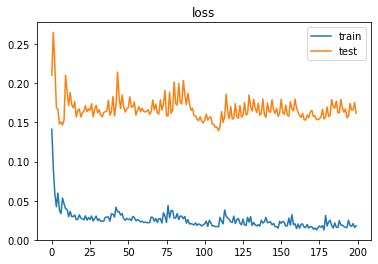

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('loss')
plt.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*(n_features-1)))
yhat=yhat[:,0]
yhat=yhat.reshape(test_X.shape[0],1)

inv_yhat = np.concatenate((yhat, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y=test_y.reshape(test_X.shape[0],1)
inv_y = np.concatenate((test_y, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

yhat=inv_yhat
test_y=inv_y

In [45]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 56.170


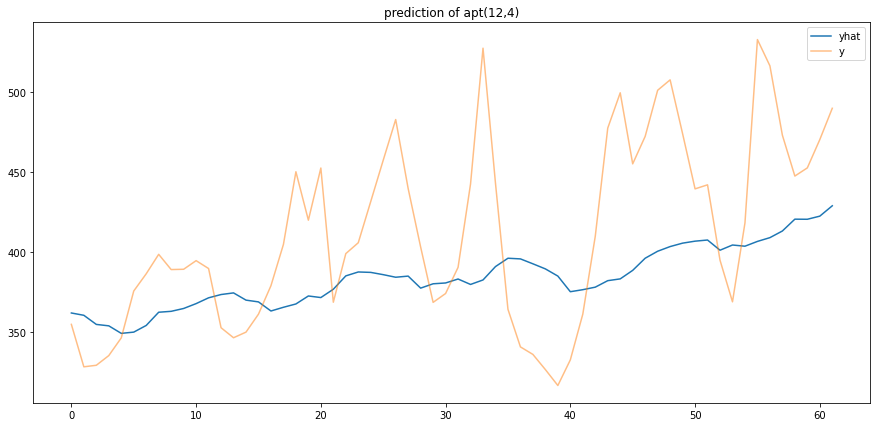

In [46]:
features=[yhat,test_y]

plt.figure(figsize=(15,7))
plt.title('prediction of apt({},{})'.format(n_months,n_features))
plt.plot(yhat,label='yhat')
plt.plot(test_y,alpha=0.5,label='y')
plt.legend()
plt.show()

# #4-1
n_months=3  
n_features=12  
apt, hloan, ir, cpi,  fed, inc, exp, savings, kospi, hccsi, bond, m2

In [47]:
values = dataset4.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_months=3
n_features=12

reframed = series_to_supervised(scaled, n_months, 1)
reframed2 = series_to_supervised(scaled, n_months, 1)

drop_col = list(range(0,n_features*n_months,n_features))+list(range(n_features*n_months+1,n_features*(n_months+1)))
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

values = reframed.values
n_train_months = 40
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 

train_X = train_X.reshape((train_X.shape[0], n_months, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features-1))

learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

history = model.fit(train_X, train_y, epochs=200, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/200
3/3 - 4s - loss: 0.1264 - val_loss: 0.3851
Epoch 2/200
3/3 - 0s - loss: 0.1239 - val_loss: 0.3412
Epoch 3/200
3/3 - 0s - loss: 0.0363 - val_loss: 0.1493
Epoch 4/200
3/3 - 0s - loss: 0.0761 - val_loss: 0.1423
Epoch 5/200
3/3 - 0s - loss: 0.0456 - val_loss: 0.1453
Epoch 6/200
3/3 - 0s - loss: 0.0392 - val_loss: 0.1314
Epoch 7/200
3/3 - 0s - loss: 0.0352 - val_loss: 0.1800
Epoch 8/200
3/3 - 0s - loss: 0.0397 - val_loss: 0.1788
Epoch 9/200
3/3 - 0s - loss: 0.0252 - val_loss: 0.1520
Epoch 10/200
3/3 - 0s - loss: 0.0382 - val_loss: 0.1706
Epoch 11/200
3/3 - 0s - loss: 0.0288 - val_loss: 0.1731
Epoch 12/200
3/3 - 0s - loss: 0.0257 - val_loss: 0.1472
Epoch 13/200
3/3 - 0s - loss: 0.0274 - val_loss: 0.1489
Epoch 14/200
3/3 - 0s - loss: 0.0246 - val_loss: 0.1527
Epoch 15/200
3/3 - 0s - loss: 0.0252 - val_loss: 0.1459
Epoch 16/200
3/3 - 0s - loss: 0.0237 - val_loss: 0.1450
Epoch 17/200
3/3 - 0s - loss: 0.0250 - val_loss: 0.1581
Epoch 18/200
3/3 - 0s - loss: 0.0256 - val_loss: 0.1483
E

Epoch 147/200
3/3 - 0s - loss: 0.0121 - val_loss: 0.1374
Epoch 148/200
3/3 - 0s - loss: 0.0131 - val_loss: 0.1368
Epoch 149/200
3/3 - 0s - loss: 0.0144 - val_loss: 0.1485
Epoch 150/200
3/3 - 0s - loss: 0.0137 - val_loss: 0.1597
Epoch 151/200
3/3 - 0s - loss: 0.0131 - val_loss: 0.1501
Epoch 152/200
3/3 - 0s - loss: 0.0133 - val_loss: 0.1426
Epoch 153/200
3/3 - 0s - loss: 0.0138 - val_loss: 0.1321
Epoch 154/200
3/3 - 0s - loss: 0.0110 - val_loss: 0.1333
Epoch 155/200
3/3 - 0s - loss: 0.0152 - val_loss: 0.1357
Epoch 156/200
3/3 - 0s - loss: 0.0089 - val_loss: 0.1490
Epoch 157/200
3/3 - 0s - loss: 0.0120 - val_loss: 0.1431
Epoch 158/200
3/3 - 0s - loss: 0.0097 - val_loss: 0.1302
Epoch 159/200
3/3 - 0s - loss: 0.0108 - val_loss: 0.1290
Epoch 160/200
3/3 - 0s - loss: 0.0113 - val_loss: 0.1292
Epoch 161/200
3/3 - 0s - loss: 0.0126 - val_loss: 0.1288
Epoch 162/200
3/3 - 0s - loss: 0.0127 - val_loss: 0.1275
Epoch 163/200
3/3 - 0s - loss: 0.0174 - val_loss: 0.1258
Epoch 164/200
3/3 - 0s - loss: 

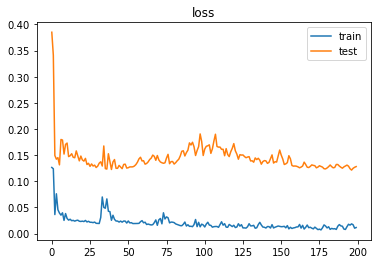

In [48]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('loss')
plt.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*(n_features-1)))
yhat=yhat[:,0]
yhat=yhat.reshape(test_X.shape[0],1)

inv_yhat = np.concatenate((yhat, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y=test_y.reshape(test_X.shape[0],1)
inv_y = np.concatenate((test_y, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

yhat=inv_yhat
test_y=inv_y

In [49]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 46.416


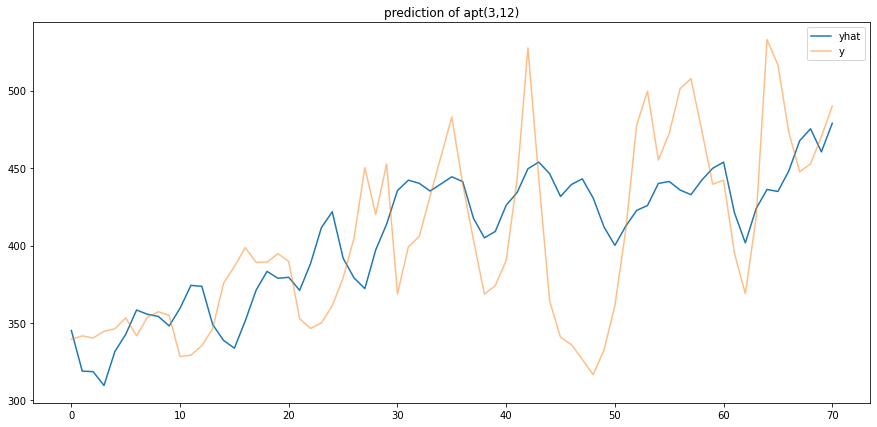

In [50]:
features=[yhat,test_y]

plt.figure(figsize=(15,7))
plt.title('prediction of apt({},{})'.format(n_months,n_features))
plt.plot(yhat,label='yhat')
plt.plot(test_y,alpha=0.5,label='y')
plt.legend()
plt.show()

# #4-2
n_months=12  
n_features=12  
apt, hloan, ir, cpi,  fed, inc, exp, savings, kospi, hccsi, bond, m2

In [51]:
values = dataset4.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_months=12
n_features=12

reframed = series_to_supervised(scaled, n_months, 1)
reframed2 = series_to_supervised(scaled, n_months, 1)

drop_col = list(range(0,n_features*n_months,n_features))+list(range(n_features*n_months+1,n_features*(n_months+1)))
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

values = reframed.values
n_train_months = 40
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 

train_X = train_X.reshape((train_X.shape[0], n_months, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features-1))

learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

history = model.fit(train_X, train_y, epochs=200, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/200
3/3 - 5s - loss: 0.2869 - val_loss: 0.5577
Epoch 2/200
3/3 - 0s - loss: 0.2804 - val_loss: 0.7949
Epoch 3/200
3/3 - 0s - loss: 0.2063 - val_loss: 0.4358
Epoch 4/200
3/3 - 0s - loss: 0.0839 - val_loss: 0.2495
Epoch 5/200
3/3 - 0s - loss: 0.1234 - val_loss: 0.2211
Epoch 6/200
3/3 - 0s - loss: 0.0808 - val_loss: 0.2334
Epoch 7/200
3/3 - 0s - loss: 0.0418 - val_loss: 0.1682
Epoch 8/200
3/3 - 0s - loss: 0.0418 - val_loss: 0.1394
Epoch 9/200
3/3 - 0s - loss: 0.0261 - val_loss: 0.1654
Epoch 10/200
3/3 - 0s - loss: 0.0482 - val_loss: 0.1710
Epoch 11/200
3/3 - 0s - loss: 0.0291 - val_loss: 0.1622
Epoch 12/200
3/3 - 0s - loss: 0.0351 - val_loss: 0.1811
Epoch 13/200
3/3 - 0s - loss: 0.0312 - val_loss: 0.1772
Epoch 14/200
3/3 - 0s - loss: 0.0272 - val_loss: 0.1615
Epoch 15/200
3/3 - 0s - loss: 0.0297 - val_loss: 0.1598
Epoch 16/200
3/3 - 0s - loss: 0.0276 - val_loss: 0.1663
Epoch 17/200
3/3 - 0s - loss: 0.0285 - val_loss: 0.1565
Epoch 18/200
3/3 - 0s - loss: 0.0246 - val_loss: 0.1597
E

Epoch 147/200
3/3 - 1s - loss: 0.0131 - val_loss: 0.1492
Epoch 148/200
3/3 - 0s - loss: 0.0135 - val_loss: 0.1459
Epoch 149/200
3/3 - 0s - loss: 0.0137 - val_loss: 0.1479
Epoch 150/200
3/3 - 0s - loss: 0.0212 - val_loss: 0.1473
Epoch 151/200
3/3 - 0s - loss: 0.0153 - val_loss: 0.1479
Epoch 152/200
3/3 - 0s - loss: 0.0169 - val_loss: 0.1558
Epoch 153/200
3/3 - 0s - loss: 0.0118 - val_loss: 0.1500
Epoch 154/200
3/3 - 0s - loss: 0.0135 - val_loss: 0.1509
Epoch 155/200
3/3 - 0s - loss: 0.0159 - val_loss: 0.1489
Epoch 156/200
3/3 - 0s - loss: 0.0116 - val_loss: 0.1479
Epoch 157/200
3/3 - 0s - loss: 0.0149 - val_loss: 0.1479
Epoch 158/200
3/3 - 0s - loss: 0.0128 - val_loss: 0.1456
Epoch 159/200
3/3 - 0s - loss: 0.0146 - val_loss: 0.1482
Epoch 160/200
3/3 - 0s - loss: 0.0242 - val_loss: 0.1503
Epoch 161/200
3/3 - 0s - loss: 0.0135 - val_loss: 0.1504
Epoch 162/200
3/3 - 0s - loss: 0.0156 - val_loss: 0.1565
Epoch 163/200
3/3 - 0s - loss: 0.0115 - val_loss: 0.1505
Epoch 164/200
3/3 - 0s - loss: 

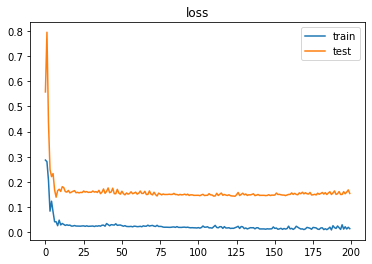

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('loss')
plt.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*(n_features-1)))
yhat=yhat[:,0]
yhat=yhat.reshape(test_X.shape[0],1)

inv_yhat = np.concatenate((yhat, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y=test_y.reshape(test_X.shape[0],1)
inv_y = np.concatenate((test_y, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

yhat=inv_yhat
test_y=inv_y

In [53]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 54.324


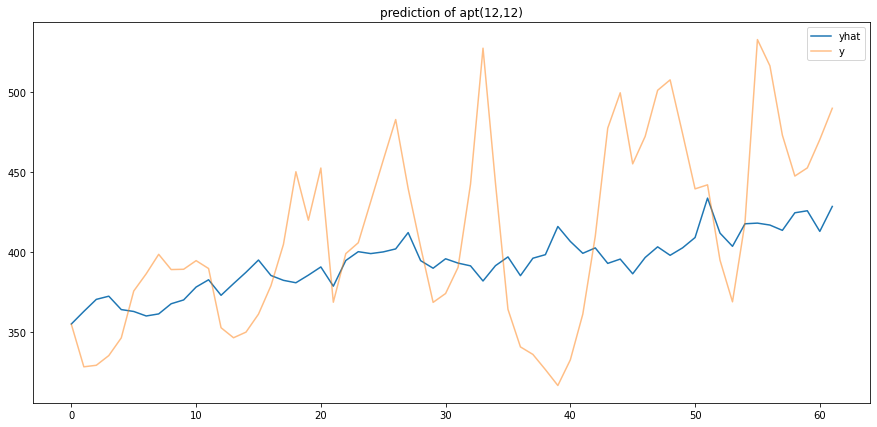

In [54]:
features=[yhat,test_y]

plt.figure(figsize=(15,7))
plt.title('prediction of apt({},{})'.format(n_months,n_features))
plt.plot(yhat,label='yhat')
plt.plot(test_y,alpha=0.5,label='y')
plt.legend()
plt.show()